# Przewidywanie ceny domków w Bostonie

## Wprowadzenie

Wykorzytsując popularny zbiór dot. domów w Bostonie stworzę model, który nauczy się przewidywać ich cenę.

Notebook powstał w ramach nauki modelowania regresji liniowej.

## Importowanie bibliotek

Będę korzystać z biblioteki:
* Pandas - do analizowania zbioru Boston House
* Matplotlib - do wizualizacji danych
* Seaborn - również do wizualizacji danych
* Scikit-learn - do pobrania setu oraz algorytmów ML

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
import statsmodels.api as sm 
import warnings

## Pobieranie i przygotowanie zbioru danych
Zbiór Boston Housing, na którym będę pracować jest dostępny do pobrania z biblioteki Scikit-Learn.

In [2]:
warnings.filterwarnings('ignore')

# Importing the Boston Housing dataset
from sklearn.datasets import load_boston
boston = load_boston()

boston_data = pd.DataFrame(boston.data)
boston_data.columns = boston.feature_names

#Adding target variable to dataframe
boston_data['PRICE'] = boston.target

W pierwszej kolejności sprawdzę czy w danych nie ma duplikatów. Modele osiągają lepsze wyniki ucząc się na danych, które się nie powtarzają.

In [3]:
#Check columns and rows 
print('Shape before deleting duplicate values:', boston_data.shape)
boston_data = boston_data.drop_duplicates()
print('Shape after deleting duplicate values:', boston_data.shape)

Shape before deleting duplicate values: (506, 14)
Shape after deleting duplicate values: (506, 14)


W secie nie było żadnych duplikatów, co jest bardzo dobrą informacją. Sprawdzę jak wygląda 5 pierwszy wierszy.

In [4]:
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Set posiada 13 kolumn ze zmiennymi opisującymi domy w Bostonie oraz 1 zmienną docelową.

Poniżej opis każdej zmiennej:

* CRIM - wskaźnik przestępczości na mieszkańca wg miast
* ZN - część gruntów mieszkalnych przeznaczonych na działki o pow. powyżej 25 000 stóp kwadratowych
* INDUS - odsetek akrów działalności niehandlowej na miasto
* CHAS  - fikcyjna zmienna Charles River (1 jest przeprawa przez rzekę, 0 nie ma przeprawy przez rzekę)
* NOX - stężenie tlenków azotu (część na 10 milionów)
* RM - średnia liczba pokoi na domek
* AGE - odsetek jednostek własnościowych wybudowanych przed 1940 
* DIS - ważone odległości do pięciu bostońskich centrów zatrudnienia
* RAD - wskaźnik dostępności do autostrad radialnych
* TAX - pełnowartościowa stawka podatku od nieruchomości za 10 000 USD
* PTRATIO - stosunek uczniów do nauczycieli wg miasta
* B 1000 - odsetek osób czarnoskórych wg miasta
* LSTAT - procentowy udział ludności o niższym statusie

**PRICE** to zmienna docelowa i jest nią średnia wartość domów zajmowanych przez właścicieli w 1 000 USD

Do algorytmu uczenia wybiorę tylko te cechy, które będą możliwie jak najbardziej wpływały na zmienną docelową.

Zmienne, które nie wpływają lub wpływają w bardzo małym stopniu na zmienną docelową będą od razu odrzucane.

In [5]:
boston_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 59.3 KB


In [6]:
boston_data.describe(include='all')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [7]:
boston_data.nunique()

CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
PRICE      229
dtype: int64

W kolumnach 'CHAS' i 'RAD' jest mniej niż 20 unikalnych wartości co może oznaczać, że są to potencjalnie zmienne kategoryczne. Sprawdzę rozkład danych tych kolumn.

<AxesSubplot:xlabel='CHAS'>

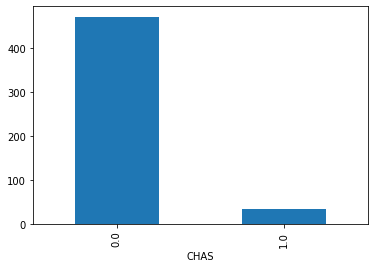

In [8]:
boston_data.groupby('CHAS').size().plot(kind='bar')


<AxesSubplot:xlabel='RAD'>

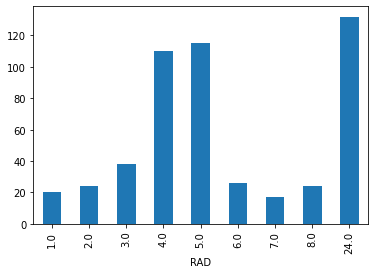

In [9]:
boston_data.groupby('RAD').size().plot(kind='bar')

Idealnie by było gdyby każda kategoria miała porównywalną ilość wystąpień. Rozkład zmiennej 'RAD' jest taki. Rozkład zmiennej 'CHAS' jest nieproporcjonalny. 

Na razie zostawie obie kolumny, ale będę je jeszcze testowała pod względem przydatności do modelu.

## Zmienna docelowa - Rozkład Gaussa

Sprawdzę czy zmienna docelowa ma normalny czyli najbardziej pożądany rozkład danych. 

Najlepiej to sobie zwizualizuje na histogramie.
O rozkładzie normalnym danych mówimy jeśli:
* dane przyjmują kształt "dzwonu"
* wykres jest symetryczny
* średnia równa się medianie
* wykres jest asymptotyczny (czyli wykres "przytula się" lub przecina prostą)
* wykres jest jednomodalny czyli posiadający jedne maksimum

<AxesSubplot:>

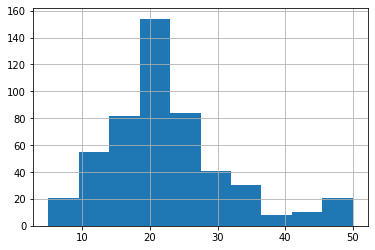

In [10]:
boston_data['PRICE'].hist()

## Test Korelacji Pearsona

Zmienna docelowa posiada cechy rozkładu normalnego, dlatego mogę wykonać test korelacji Pearsona i sprawdzić jaki wpływ mają na siebie zmienne ilościowe. Dlatego muszę wykluczyć z testu zmienne 'CHAS' i 'RAD'.

Najlepiej to można zobaczyć na mapie cieplnej. 
Wyniki korelacji są wyrażone liczbami z przedziału od -1 do 1. 

Im dalej od 0 (nie ważne w którą stronę) tym silniejsza jest korelacja zmiennych predykcyjnych ze zmienną docelową.

Jeżeli wartości są ujemne to znaczy, że zmienna predykcyjna maleje wraz ze wzrostem zmiennej docelowej.
Analogicznie jeżeli wartość jest dodatnia to znaczy, że wraz ze wzrostem zmiennej predykcyjnej rośnie również zmienna docelowa.

In [11]:
# Finding out the correlation between the features
quantitative_variables = ['PRICE', 'CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
corr = boston_data[quantitative_variables].corr(method='pearson')
corr.shape

(12, 12)

<AxesSubplot:>

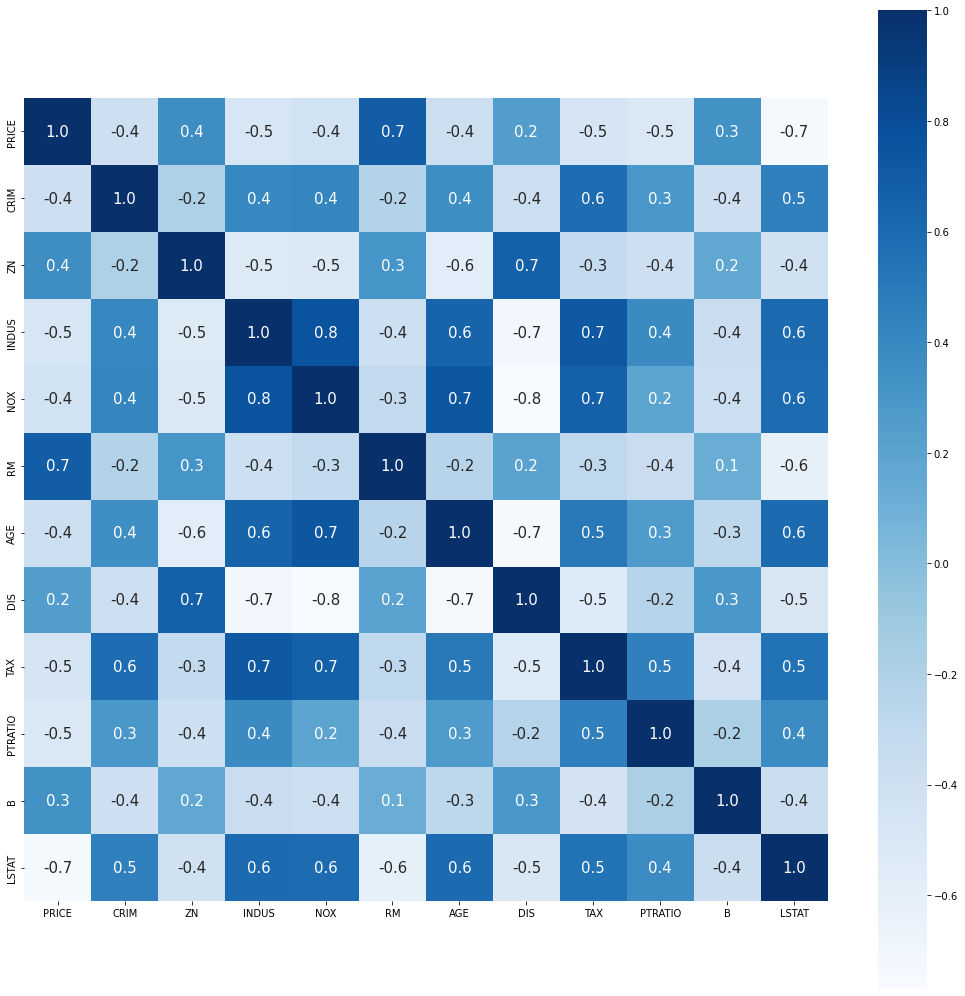

In [12]:
# Plotting the heatmap of correlation between features
plt.figure(figsize=(18,18))
sns.heatmap(corr, cbar= True, square= True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='Blues')

In [13]:
corr['PRICE'][abs(corr['PRICE']) >= 0.5]

PRICE      1.000000
RM         0.695360
PTRATIO   -0.507787
LSTAT     -0.737663
Name: PRICE, dtype: float64

Patrząc na powyższą mapę korelacji oraz odfiltrowane dane przy założeniu, że korelacja jest większa lub równa 0.50 mogę dokonać wstępnej selekcji zmiennych do algrotymu uczenia modelu. 

* ~~CRIM~~ - słaba korelacja, kolumna odrzucona
* ~~ZN~~ - słaba korelacja, kolumna odrzucona
* ~~INDUS~~ - słaba korelacja, kolumna odrzucona 
* ~~NOX~~ - słaba korelacja, kolumna odrzucona
* **RM** - najlepsza korelacja dodatnia, kolumna zostaje
* ~~AGE~~ - słaba korelacja, kolumna odrzucona
* ~~DIS~~ - słaba korelacja, kolumna odrzucona
* ~~TAX~~ - umiarkowana korelacja, kolumna odrzucona
* **PTRATIO** - dobra korelacja, kolumna zostaje
* ~~B 1000~~ - słaba korelacja, kolumna odrzucona
* **LSTAT** - najlepsza odwrócona korelacja, kolumna zostaje

Sprawdzę rozkład danych zmiennych, które zostają w modelu.

array([[<AxesSubplot:title={'center':'RM'}>,
        <AxesSubplot:title={'center':'PTRATIO'}>],
       [<AxesSubplot:title={'center':'LSTAT'}>, <AxesSubplot:>]],
      dtype=object)

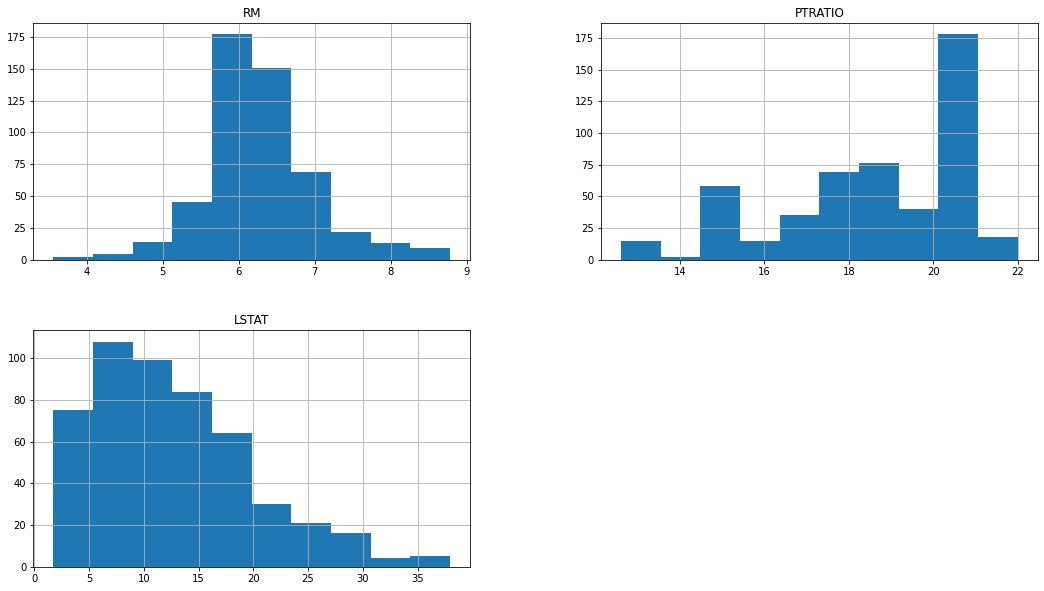

In [14]:
boston_data.hist(['RM', 'PTRATIO', 'LSTAT'], figsize=(18,10))

Patrząc na powyższe histogramy metodą "na oko" można stwierdzić, że zmiena RM jako jedyna ma rozkład normalny. Zostaje mocnym faworytem do modelu regresji liniowej.

## Test ANOVA

Testem Anova sprawdzę czy zmienne kategoryczne 'CHAS' i 'RAD' są skorelowane ze zmienną docelową 'PRICE', która jest jednocześnie zmienną ilościową.

### 1. Formułowanie hipotezy

Hipoteza zerowa - zmienna nie ma związku ze zmienną docelową
Hipoteza alternatywna - zmienna ma związek ze zmienną docelową

### 2. Określenie poziomu istotności

Istotność ustalam jako 5% prawdopodobieństwa, czyli 0.05. Jeżeli wartość p będzie poniżej 0.05 to zmienna jest skorelowana ze zmienną docelową.

In [15]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ANOVA test

model = ols('PRICE ~ CHAS + RAD', data=boston_data).fit()
anova = sm.stats.anova_lm(model, typ=2)

anova

,sum_sq,df,F,PR(>F)
CHAS,1270.383399,1.0,18.140724,2.449187e-05
RAD,6179.444731,1.0,88.240763,2.017557e-19
Residual,35224.771413,503.0,NaN,NaN


## Przygotowanie zbioru treningowego i testowego

Przygotuje sobie ostatecznie wybrane zmienne oraz zmienną docelową do odrębnego zbioru na którym dokonam normalizacji danych i ostatecznego podziału na zbiór treningowy i testowy, w stosunku 70% do 30%.

In [16]:
selected_columns = ['RM', 'PTRATIO', 'LSTAT', 'RAD', 'CHAS']

data_for_ml = boston_data[selected_columns]
data_for_ml['PRICE'] = boston_data['PRICE']
data_for_ml.head()

,RM,PTRATIO,LSTAT,RAD,CHAS,PRICE
0,6.575,15.3,4.98,1.0,0.0,24.0
1,6.421,17.8,9.14,2.0,0.0,21.6
2,7.185,17.8,4.03,2.0,0.0,34.7
3,6.998,18.7,2.94,3.0,0.0,33.4
4,7.147,18.7,5.33,3.0,0.0,36.2


In [18]:
target = 'PRICE'

x = data_for_ml[selected_columns].values
y = data_for_ml[target].values

# Normalizacja danych

from sklearn.preprocessing import MinMaxScaler

skaler = MinMaxScaler()
skaler_fit = skaler.fit(x)
x = skaler_fit.transform(x)


# Podział danych na model treningowy i testowy
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


# Sprawdzenie liczby kolumn i wierszy po podziale

print('Zbiór x treningowy: ', x_train.shape)
print('Zbiór y treningowy: ', y_train.shape)
print('Zbiór x testowy: ', x_test.shape)
print('Zbiór y testowy: ', y_test.shape)

Zbiór x treningowy:  (354, 5)
Zbiór y treningowy:  (354,)
Zbiór x testowy:  (152, 5)
Zbiór y testowy:  (152,)
